In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel, DistilBertTokenizer,get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time


In [2]:
# Load the dataset
# Load the dataset
file_path = '42_augmented_synonym_clean.csv'#'cleaned_dataset_49_update_real_augment.csv' 
df = pd.read_csv(file_path)
df.head()



,Title,Description
0,Receptionist,AMERIA Closed Joint Stock Company seeking Rece...
1,Receptionist,VTnova LLC invite application highly qualified...
2,Lawyer,UMCOR United Methodist Committee Relief Armeni...
3,Lawyer,ACRA Credit Bureau announcing open position at...
4,Cook,Committed person fulfil position Chief Cook


In [3]:
df.shape

(17370, 2)

In [4]:
df["Title"].nunique()

42

In [5]:
df=df[['Title','Description']]

<Axes: xlabel='Title', ylabel='Count'>

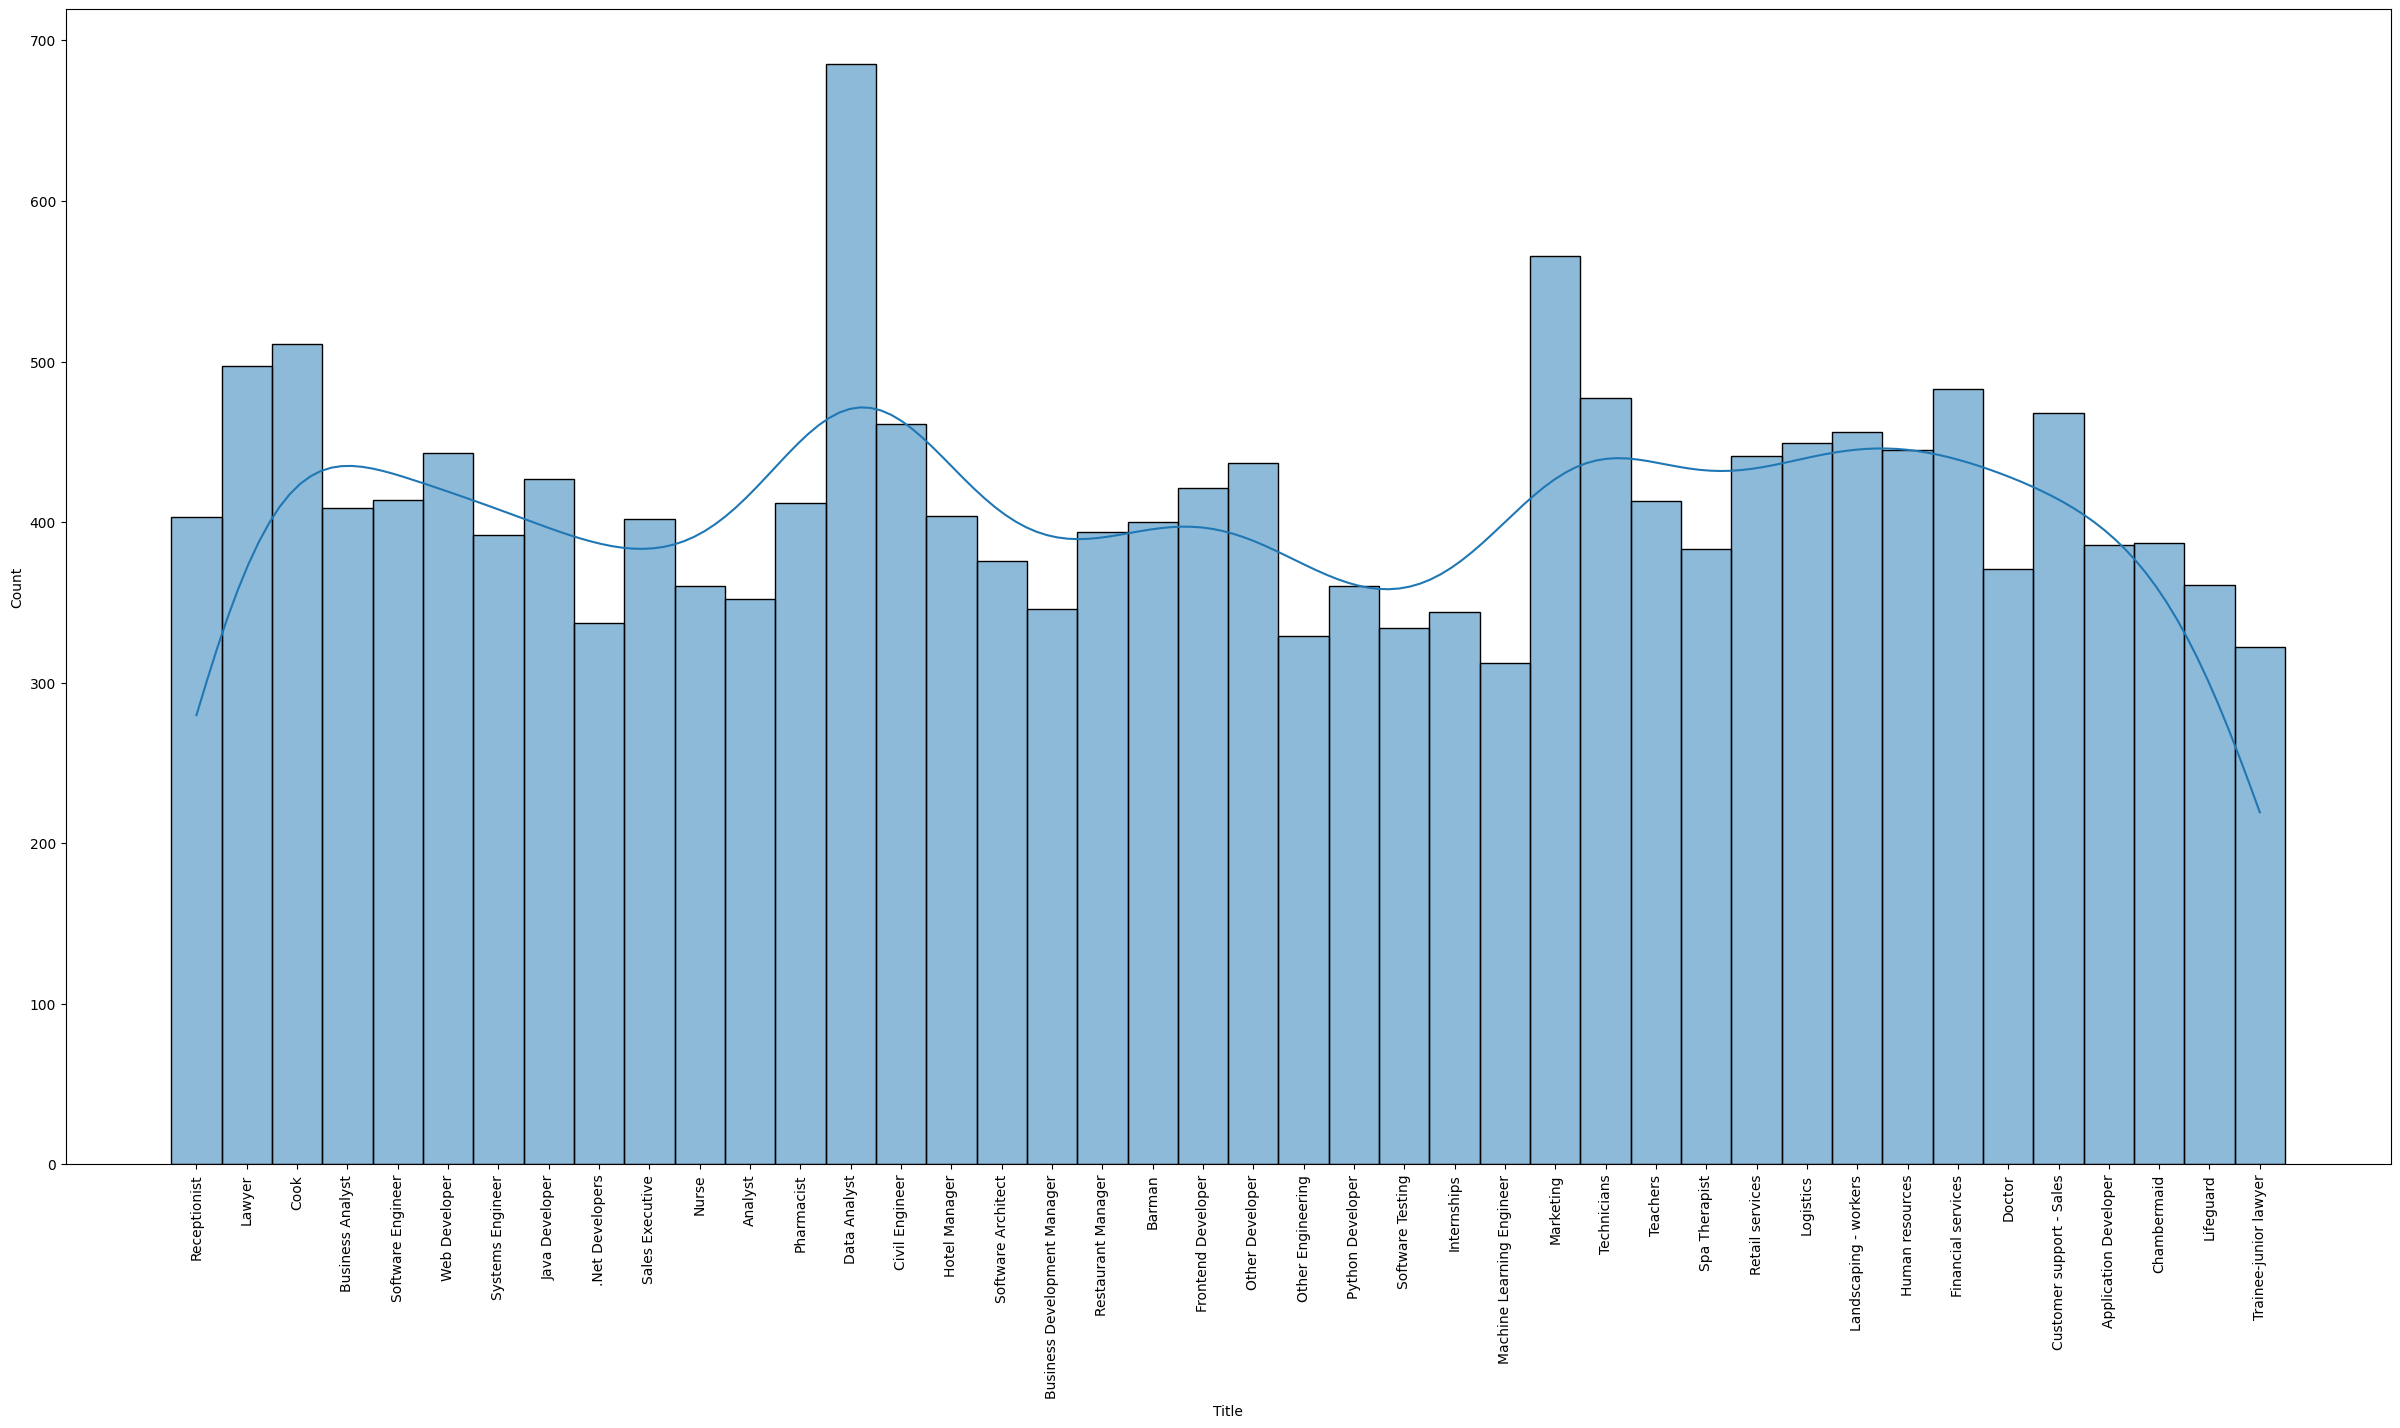

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(30,15))
plt.xticks(rotation=90)
sns.histplot(x=df['Title'],kde=True)

In [7]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Label encoding for the 'Title' column
label_encoder = LabelEncoder()
df['Title'] = label_encoder.fit_transform(df['Title'])

# Split the dataset into training, validation, and testing sets (80%, 10%, 10%)
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

train_texts, val_texts, test_texts = np.split(df.sample(frac=1, random_state=42), [train_size, train_size + val_size])

# Tokenize the texts
def tokenize_function(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_function(train_texts['Description'])
val_encodings = tokenize_function(val_texts['Description'])
test_encodings = tokenize_function(test_texts['Description'])

C:\Users\AIMVLab\.conda\envs\GPU\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
class JobMatchingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

# Create the dataset objects
train_dataset = JobMatchingDataset(train_encodings, train_texts['Title'])
val_dataset = JobMatchingDataset(val_encodings, val_texts['Title'])
test_dataset = JobMatchingDataset(test_encodings, test_texts['Title'])


In [9]:
class JobMatchingModel(nn.Module):
    def __init__(self, distilbert_model):
        super(JobMatchingModel, self).__init__()
        self.distilbert = distilbert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.distilbert.config.hidden_size, len(label_encoder.classes_))

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[0][:, 0]  # Use the [CLS] token representation
        output = self.drop(pooled_output)
        return self.out(output)


In [10]:
batch_size = 16  # Adjusted for hardware constraints
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [11]:

num_epochs=4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = JobMatchingModel(distilbert_model=DistilBertModel.from_pretrained('distilbert-base-uncased'))
model = model.to(device)

# Define optimizer with appropriate hyperparameters
optimizer = torch.optim.AdamW(params=model.parameters(), lr=5e-5,eps=1e-6, weight_decay=0.01)
# Define loss function
criterion = nn.CrossEntropyLoss()

# Total training steps
total_steps = len(train_loader) * num_epochs

# Define the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [12]:


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

start_time=time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_examples = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_examples += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_examples

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss}, Training Accuracy: {accuracy}')
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_examples = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_correct_predictions += (preds == labels).sum().item()
            val_total_examples += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_examples

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}')



Epoch 1/4, Training Loss: 0.809296016211614, Training Accuracy: 0.8033246977547496
Epoch 1/4, Validation Loss: 0.30023189607597545, Validation Accuracy: 0.9217040875071963
Epoch 2/4, Training Loss: 0.23152469481385482, Training Accuracy: 0.9406303972366149
Epoch 2/4, Validation Loss: 0.231848318343384, Validation Accuracy: 0.9401266551525619
Epoch 3/4, Training Loss: 0.10517586793180371, Training Accuracy: 0.9743091537132987
Epoch 3/4, Validation Loss: 0.1847780962824958, Validation Accuracy: 0.9585492227979274
Epoch 4/4, Training Loss: 0.05008684738964631, Training Accuracy: 0.9889176741508348
Epoch 4/4, Validation Loss: 0.17975308947102808, Validation Accuracy: 0.9614277489925158


In [13]:
end_time=time.time()
training_time=end_time-start_time
# Convert the training time to hh:mm:ss format
training_time_hms = time.strftime('%H:%M:%S', time.gmtime(training_time))

print('Total training Time for DistilBERT : ',training_time_hms)



Total training Time for DistilBERT :  00:10:53


In [14]:
# Save results to a DataFrame
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Validation Loss': val_losses,
    'Validation Accuracy': val_accuracies
})

results_df.head()


,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,0.809296,0.803325,0.300232,0.921704
1,2,0.231525,0.940630,0.231848,0.940127
2,3,0.105176,0.974309,0.184778,0.958549
3,4,0.050087,0.988918,0.179753,0.961428


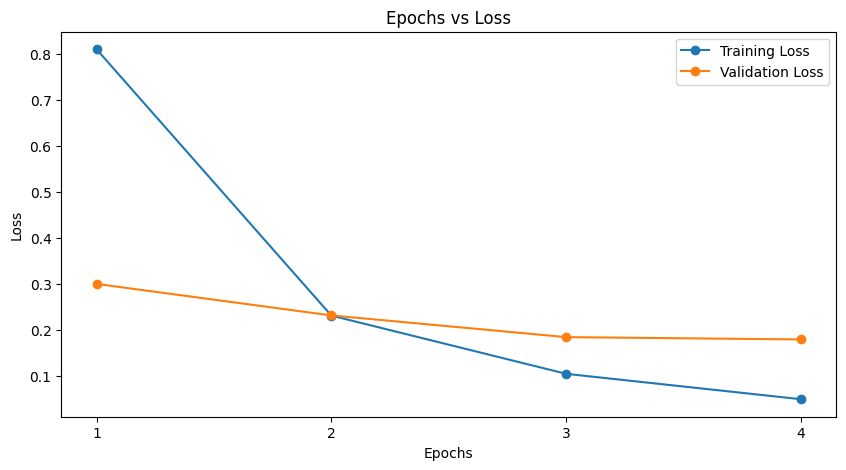

In [15]:
import matplotlib.pyplot as plt

# Plot Loss over Epochs
plt.figure(figsize=(10, 5))
plt.plot(results_df['Epoch'], results_df['Train Loss'], marker='o', label='Training Loss')
plt.plot(results_df['Epoch'], results_df['Validation Loss'], marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.xticks([1,2,3,4])
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()



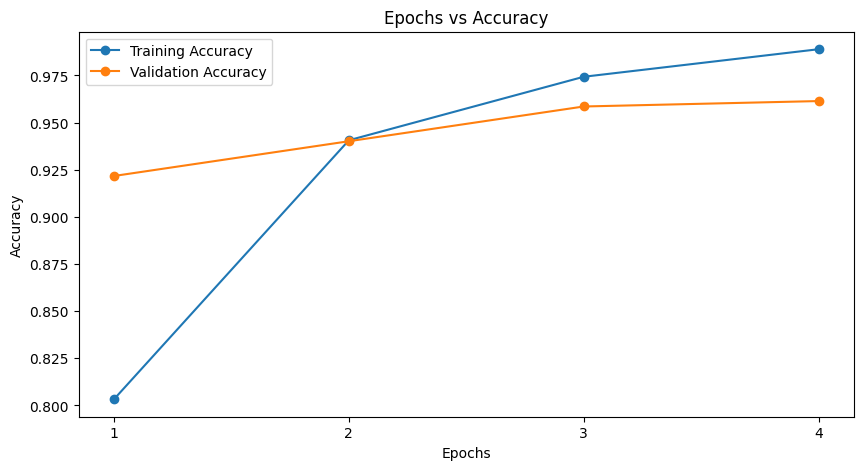

In [16]:
# Plot Accuracy over Epochs
plt.figure(figsize=(10, 5))
plt.plot(results_df['Epoch'], results_df['Train Accuracy'], marker='o', label='Training Accuracy')
plt.plot(results_df['Epoch'], results_df['Validation Accuracy'], marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks([1,2,3,4])
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
predictions, true_labels = [], []

test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)


with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')


Accuracy: 0.9545192861255037, Precision: 0.9553839532806719, Recall: 0.9545192861255037, F1 Score: 0.9544756161636576


In [18]:
from sklearn.metrics import classification_report
import numpy as np

# Finding the number of unique classes in both true labels
unique_classes = np.unique(true_labels)

# Inversely transforming the unique classes to get their names
class_names = label_encoder.inverse_transform(unique_classes)


# Generating the classification report
print(classification_report(true_labels, predictions, labels=unique_classes, target_names=class_names))

                              precision    recall  f1-score   support

             .Net Developers       0.97      0.91      0.94        34
                     Analyst       0.86      0.86      0.86        35
       Application Developer       1.00      1.00      1.00        34
                      Barman       0.97      1.00      0.99        39
            Business Analyst       0.93      0.80      0.86        49
Business Development Manager       0.97      0.95      0.96        39
                 Chambermaid       1.00      1.00      1.00        36
              Civil Engineer       0.95      0.98      0.96        42
                        Cook       1.00      1.00      1.00        54
    Customer support - Sales       0.98      0.98      0.98        46
                Data Analyst       0.77      0.86      0.81        57
                      Doctor       1.00      1.00      1.00        32
          Financial services       0.98      0.95      0.96        55
          Frontend 

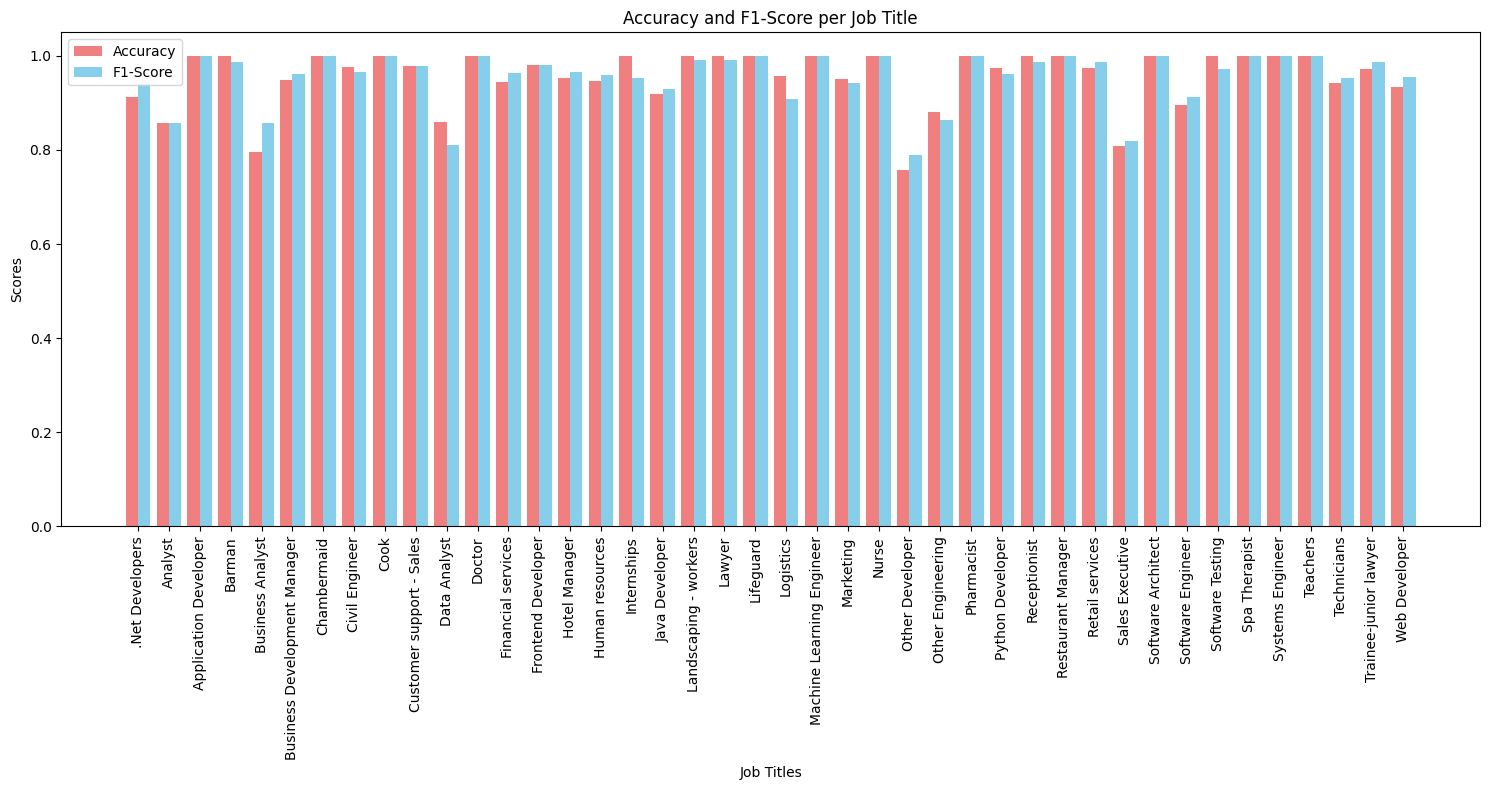

In [19]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

# Convert true_labels and predictions to numpy arrays (if they aren't already)
true_labels_np = np.array(true_labels)
predictions_np = np.array(predictions)

# Get the classification report as a dictionary
report = classification_report(true_labels_np, predictions_np, labels=unique_classes, target_names=class_names, output_dict=True)

# Extract the F1-scores for each class
f1_scores = [report[title]['f1-score'] for title in label_encoder.classes_]

# Calculate the accuracy per class
accuracy_per_class = []
for i, title in enumerate(label_encoder.classes_):
    # Mask to filter only the samples that belong to class i
    class_mask = (true_labels_np == i)
    
    # Calculate accuracy for class i
    class_accuracy = accuracy_score(true_labels_np[class_mask], predictions_np[class_mask])
    accuracy_per_class.append(class_accuracy)

# Plotting the F1-scores and Accuracy for each class
plt.figure(figsize=(15, 8))
x = np.arange(len(label_encoder.classes_))

# Plot accuracy and F1-score with gentle colors
plt.bar(x - 0.2, accuracy_per_class, 0.4, label='Accuracy', color='#F08080')  # Peach
plt.bar(x + 0.2, f1_scores, 0.4, label='F1-Score', color='#87CEEB')  # Lavender

# Customize the plot
plt.xticks(x, label_encoder.classes_, rotation=90)
plt.xlabel('Job Titles')
plt.ylabel('Scores')
plt.title('Accuracy and F1-Score per Job Title')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Plotting F1 Scores per Job Title (Line Plot)
plt.figure(figsize=(15, 6))
x = np.arange(len(label_encoder.classes_))
plt.plot(label_encoder.classes_, f1_scores, marker='o', linestyle='-', color='#87CEEB')  # Lavender
plt.xticks(x, label_encoder.classes_, rotation=90)
plt.xlabel('Job Titles')
plt.ylabel('F1 Score')
plt.title('F1 Score per Job Title')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# Plotting Accuracy per Job Title (Line Plot)
plt.figure(figsize=(15, 6))
plt.plot(label_encoder.classes_, accuracy_per_class, marker='o', linestyle='-', color='#F08080')  # Peach
plt.xticks(x, label_encoder.classes_, rotation=90)
plt.xlabel('Job Titles')
plt.ylabel('Accuracy')
plt.title('Accuracy per Job Title')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:

# Plotting selected Job Titles using a line plot (for better visualization of trends)
selected_titles = ['Software Architect', 'Doctor', 'Python Developer', 'Analyst','Other Developer','Other Engineering',
                   'Sales Executive','Software Engineer','Data Analyst','Spa Therapist','Teachers','Application Developer']  # Example of some job titles
selected_indices = [label_encoder.transform([title])[0] for title in selected_titles]

# Plotting F1 Scores for selected job titles
plt.figure(figsize=(10, 5))
plt.plot(selected_titles, [f1_scores[i] for i in selected_indices], marker='o', linestyle='-', color='b', label='F1 Score')
plt.xlabel('Job Titles')
plt.ylabel('F1 Score')
plt.title('F1 Score for Selected Job Titles')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# Plotting Accuracy for selected job titles
plt.figure(figsize=(10, 5))
plt.plot(selected_titles, [accuracy_per_class[i] for i in selected_indices], marker='o', linestyle='-', color='r', label='Accuracy')
plt.xlabel('Job Titles')
plt.ylabel('Accuracy')
plt.title('Accuracy for Selected Job Titles')
plt.grid(True)
plt.tight_layout()
plt.show()

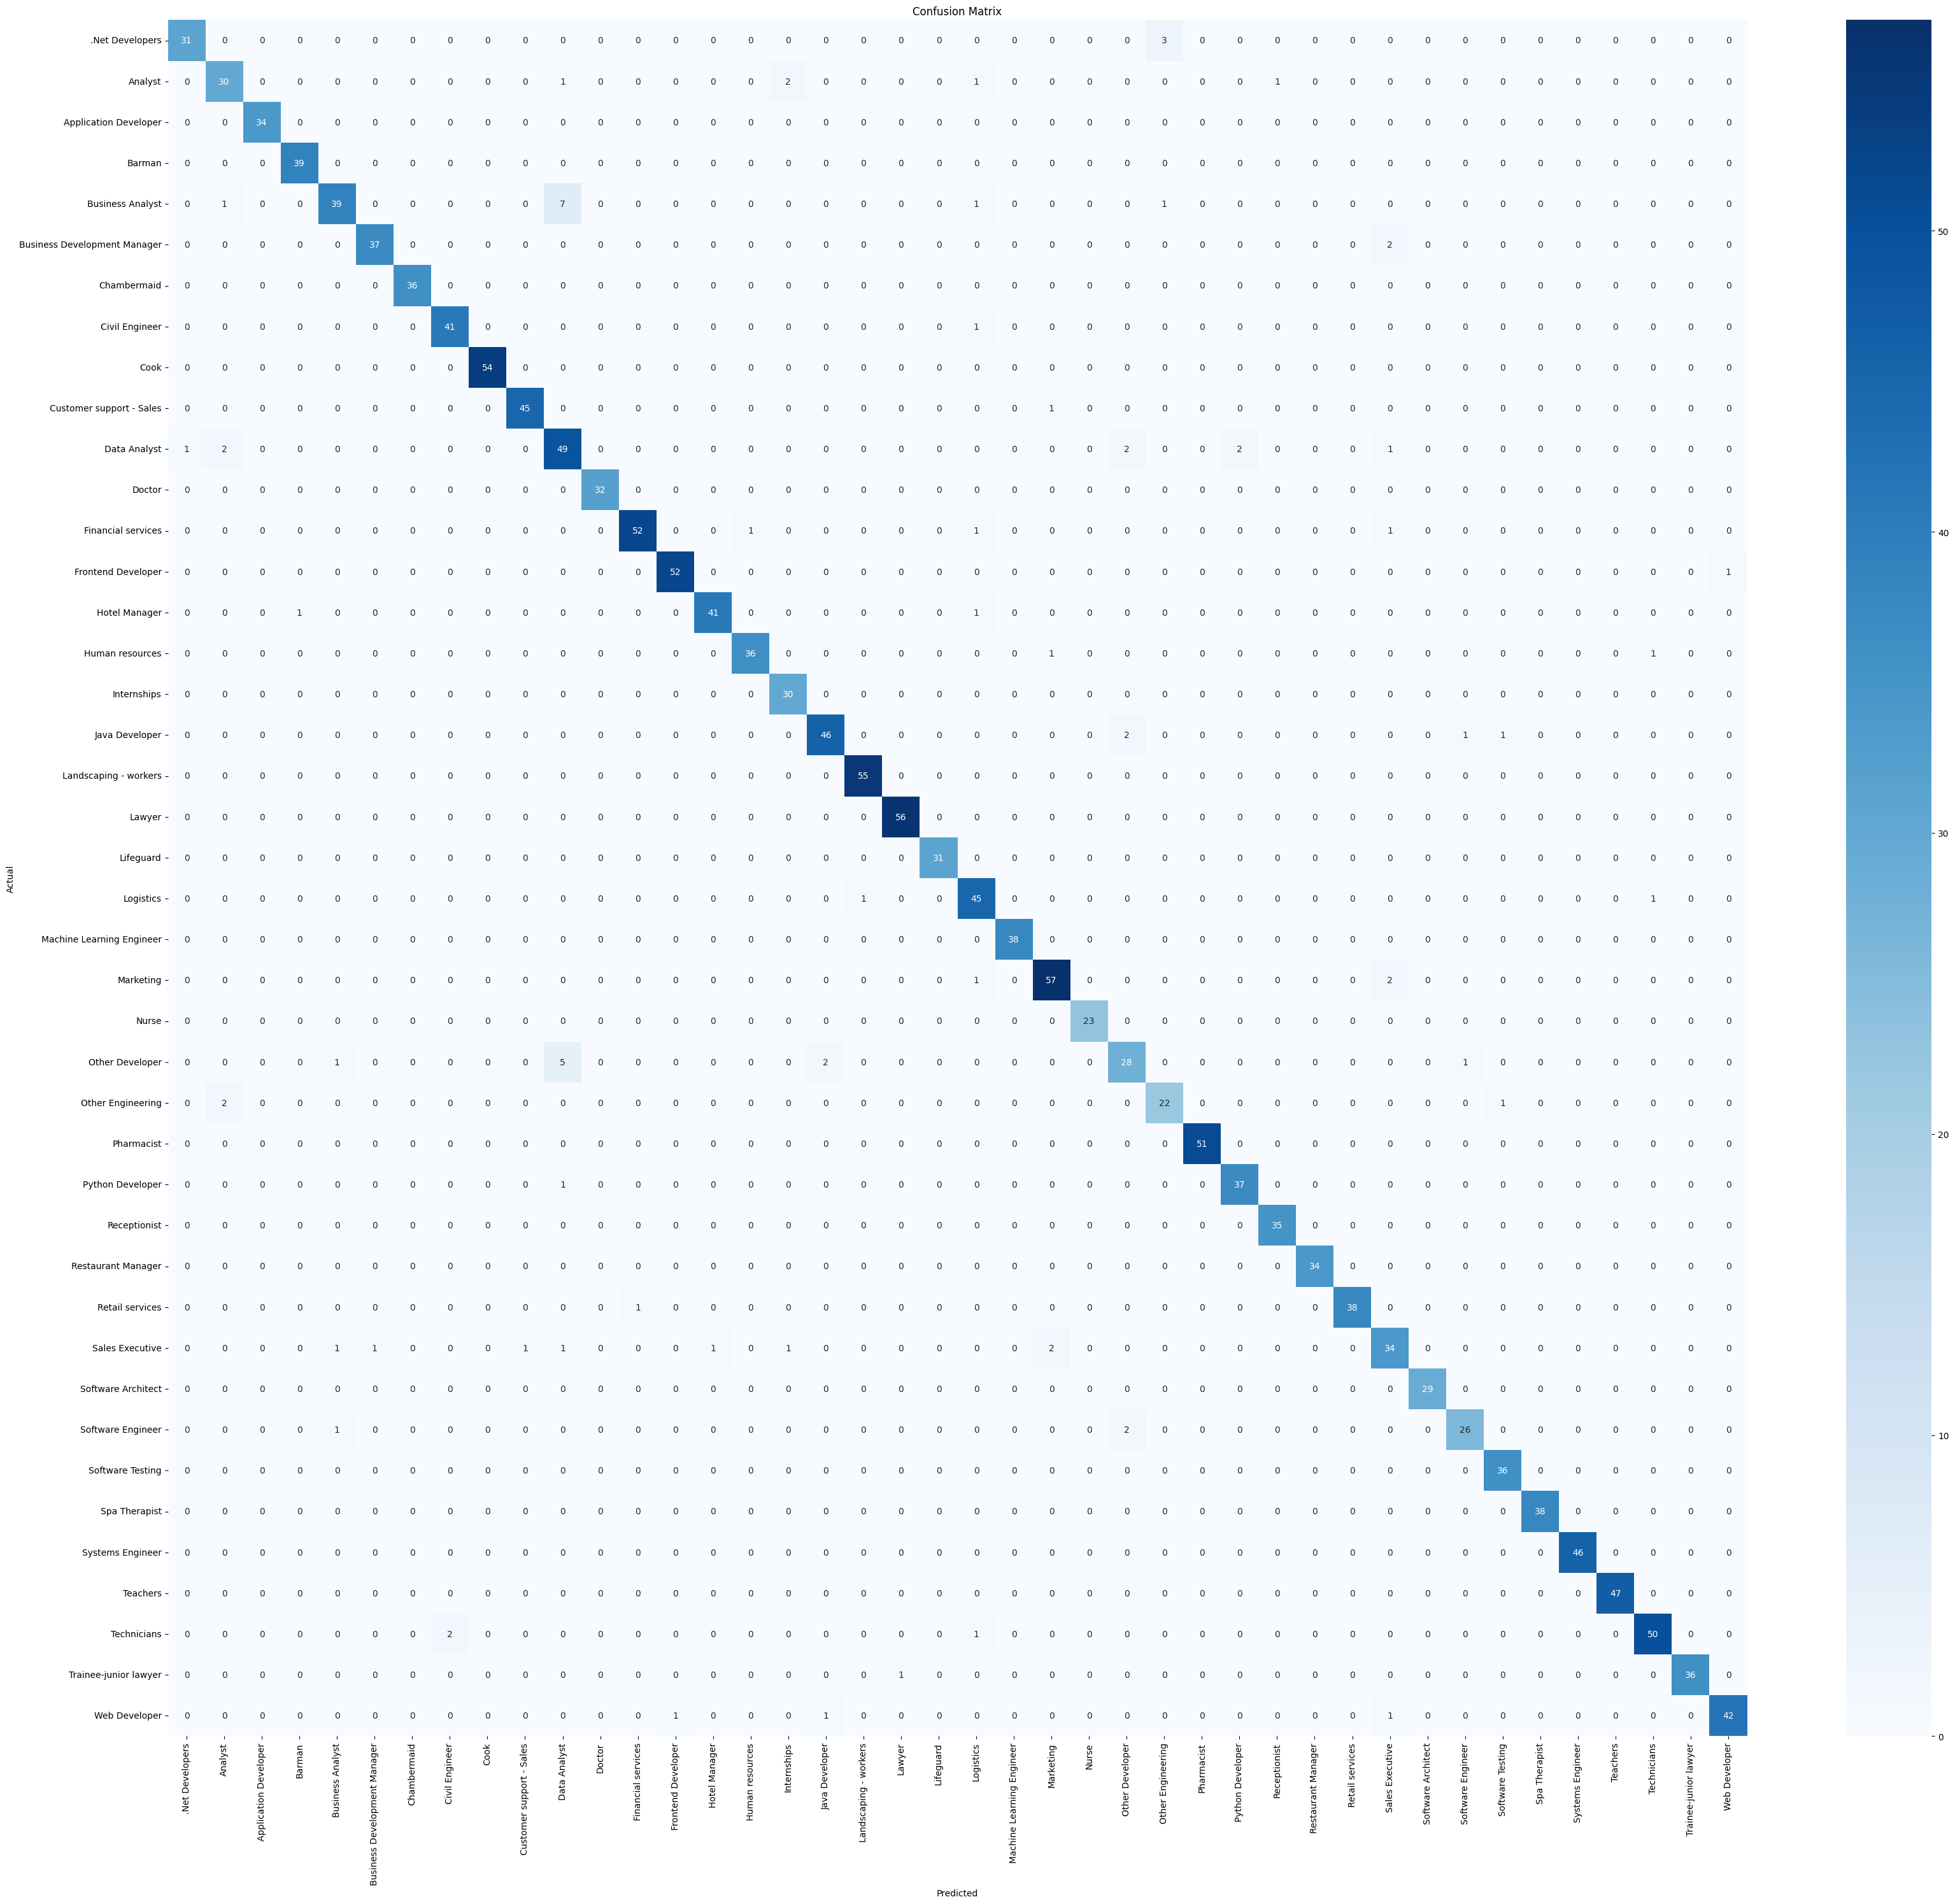

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(40, 35))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


#### Saving the model

In [21]:
# Assuming 'model' is your trained DistilBERT model
model_save_path = 'distilbert_job_matching_model.pth'
torch.save(model.state_dict(), model_save_path)


In [23]:
# Define the model architecture first
distilbert_model = JobMatchingModel(distilbert_model=DistilBertModel.from_pretrained('distilbert-base-uncased'))
distilbert_model.load_state_dict(torch.load('distilbert_job_matching_model.pth'))
distilbert_model.to(device)

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [24]:
import nltk  # Natural Language Toolkit, a comprehensive library for working with human language data.
import re # regular expressions, allowing for complex string searching and manipulation.
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, sent_tokenize, word_tokenize  # NLTK (Natural Language Toolkit) for natural language processing: pos_tag for part-of-speech tagging, sent_tokenize for sentence tokenization, word_tokenize for word tokenization.
from nltk.corpus import stopwords  # Provides a list of 'stopwords' that can be filtered out from text data.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AIMVLab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:

def cleanResume(txt):
    # Ensure input is a string
    if isinstance(txt, str):
        # Remove URLs
        cleanText = re.sub('http\S+\s', ' ', txt)
        # Remove hashtags
        cleanText = re.sub('#\S+\s', ' ', cleanText)
        # Remove mentions
        cleanText = re.sub('@\S+', '  ', cleanText)
        # Remove punctuation
        cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
        # Remove non-ASCII characters
        cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText)
        # Normalize whitespace
        cleanText = re.sub('\s+', ' ', cleanText)

        sentences = sent_tokenize(cleanText) # Tokenize the text into sentences
        features = '' # Initialize the output text
        stop_words = set(stopwords.words("english")) # Define English stop words
        lemmatizer = WordNetLemmatizer() # Initialize the WordNet lemmatizer

        for sent in sentences:
            words = word_tokenize(sent) # Tokenize the sentence into words
            words = [word for word in words if word not in stop_words] # Filter out stop words
            tagged_words = pos_tag(words) # Tag words with their parts of speech
            filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']] # Filter out certain POS tags
            lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words] # Lemmatize the filtered words
            features += " ".join(lemmatized_words) + " " # Add lemmatized words to features

        return features.strip() # Return the processed features, stripped of any extra spaces
    else:
        return txt  # Return the input as is if it's not a string


In [26]:
myresume='''

Job Summary: The Business Analyst will collaborate with various departments and stakeholders to gather, document,
and analyze business requirements, processes, and workflows. They will translate these requirements into functional 
specifications for technology teams and work closely with project managers, developers, and testers to ensure successful project delivery. 
The Business Analyst will also be involved in identifying areas for process improvement and recommending solutions to enhance operational 
efficiency and effectiveness.

Responsibilities:

1. Requirement Elicitation and Analysis:

Work closely with business stakeholders to understand their needs, objectives, and challenges.
Elicit, document, and analyze business requirements, processes, and workflows.
Translate business requirements into clear and concise functional specifications for technical teams.
2. Solution Design:

Collaborate with technology teams to design solutions that meet business needs.
Propose innovative and practical solutions to address business challenges.
Ensure that proposed solutions align with the organization's strategic goals and technological capabilities.
3. Stakeholder Communication:

Serve as a liaison between business stakeholders and technology teams.
Communicate complex technical concepts to non-technical stakeholders.
Present findings, recommendations, and project updates to various audiences.
4. Documentation:

Create detailed documentation including business requirements, process flows, use cases, and user stories.
Maintain accurate and up-to-date project documentation throughout the project lifecycle.
5. Project Management:

Collaborate with project managers to define project scope, objectives, and deliverables.
Assist in project planning, estimation, and resource allocation.
Monitor project progress and identify potential risks or deviations from the plan.
6. Quality Assurance:

Participate in system testing, user acceptance testing, and validation of implemented solutions.
Ensure that delivered solutions meet the specified requirements and are of high quality.
7. Process Improvement:

Identify areas for process optimization and efficiency enhancement.
Recommend process improvements and assist in their implementation.
Qualifications:

Bachelor's degree in Business Administration, Information Technology, or a related field (Master's degree is a plus).
Proven experience as a Business Analyst or in a related role.
Strong analytical, problem-solving, and critical-thinking skills.
Excellent communication and interpersonal abilities.
Proficiency in requirement gathering techniques, process modeling, and documentation.
Familiarity with project management methodologies and software development lifecycle.
Ability to collaborate effectively with cross-functional teams.
Knowledge of relevant tools such as Microsoft Visio, JIRA, Confluence, etc.
Certification in Business Analysis (e.g., CBAP, CCBA) is advantageous.

'''
cleaned_resume = cleanResume(myresume)




In [27]:
def predict_job_title(model, tokenizer, resume_text):
    # Preprocess and tokenize the resume text
    inputs = tokenizer(
        resume_text,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move inputs to the device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

    # Convert predicted label to job title
    predicted_label = preds.cpu().numpy()[0]
    job_title = label_encoder.inverse_transform([predicted_label])

    return job_title[0]

prediction = predict_job_title(model, tokenizer, cleaned_resume)
#print(f'Predicted Job Title: {prediction}')

In [28]:
if prediction == 'Data Analyst':
    print("The Given Job description is for Data Analyst")
elif prediction == 'Marketing':
    print("The Given Job description is for Marketing")
elif prediction == 'Cook':
    print("The Given Job description is for Cook")
elif prediction == 'Lawyer':
    print("The Given Job description is for Lawyer")
elif prediction == 'Financial services':
    print("The Given Job description is for Financial services")
elif prediction == 'Technicians':
    print("The Given Job description is for Technicians")
elif prediction == 'Customer support - Sales':
    print("The Given Job description is for Customer support - Sales")
elif prediction == 'Civil Engineer':
    print("The Given Job description is for Civil Engineer")
elif prediction == 'Landscaping - workers':
    print("The Given Job description is for Landscaping - workers")
elif prediction == 'Logistics':
    print("The Given Job description is for Logistics")
elif prediction == 'Human resources':
    print("The Given Job description is for Human resources")
elif prediction == 'Web Developer':
    print("The Given Job description is for Web Developer")
elif prediction == 'Retail services':
    print("The Given Job description is for Retail services")
elif prediction == 'Other Developer':
    print("The Given Job description is for Other Developer")
elif prediction == 'Java Developer':
    print("The Given Job description is for Java Developer")
elif prediction == 'Frontend Developer':
    print("The Given Job description is for Frontend Developer")
elif prediction == 'Software Engineer':
    print("The Given Job description is for Software Engineer")
elif prediction == 'Teachers':
    print("The Given Job description is for Teachers")
elif prediction == 'Pharmacist':
    print("The Given Job description is for Pharmacist")
elif prediction == 'Business Analyst':
    print("The Given Job description is for Business Analyst")
elif prediction == 'Hotel Manager':
    print("The Given Job description is for Hotel Manager")
elif prediction == 'Receptionist':
    print("The Given Job description is for Receptionist")
elif prediction == 'Sales Executive':
    print("The Given Job description is for Sales Executive")
elif prediction == 'Barman':
    print("The Given Job description is for Barman")
elif prediction == 'Restaurant Manager':
    print("The Given Job description is for Restaurant Manager")
elif prediction == 'Systems Engineer':
    print("The Given Job description is for Systems Engineer")
elif prediction == 'Chambermaid':
    print("The Given Job description is for Chambermaid")
elif prediction == 'Application Developer':
    print("The Given Job description is for Application Developer")
elif prediction == 'Spa Therapist':
    print("The Given Job description is for Spa Therapist")
elif prediction == 'Software Architect':
    print("The Given Job description is for Software Architect")
elif prediction == 'Doctor':
    print("The Given Job description is for Doctor")
elif prediction == 'Lifeguard':
    print("The Given Job description is for Lifeguard")
elif prediction == 'Python Developer':
    print("The Given Job description is for Python Developer")
elif prediction == 'Nurse':
    print("The Given Job description is for Nurse")
elif prediction == 'Analyst':
    print("The Given Job description is for Analyst")
elif prediction == 'Business Development Manager':
    print("The Given Job description is for Business Development Manager")
elif prediction == 'Internships':
    print("The Given Job description is for Internships")
elif prediction == '.Net Developers':
    print("The Given Job description is for .Net Developers")
elif prediction == 'Software Testing':
    print("The Given Job description is for Software Testing")
elif prediction == 'Other Engineering':
    print("The Given Job description is for Other Engineering")
elif prediction == 'Trainee-junior lawyer':
    print("The Given Job description is for Trainee-junior lawyer")
elif prediction == 'Machine Learning Engineer':
    print("The Given Job description is for Machine Learning Engineer")
else:
    print("Unknown Job Description")


The Given Job description is for Business Analyst
